In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, median_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from scipy.stats import *
import h3
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from datetime import datetime
from math import floor
import matplotlib.pyplot as plt

In [2]:
ride_columns = ['accepted_driver_id', 'created_at', 'passenger_id', 'source_lat',
       'source_lng', 'destination_lat', 'destination_lng', 'eta', 'provider',
       'ata', 'id', 'city']

khatkesh_columns = ['ride_id','driver_id','a_t_a_result.arrival_a_t_a','a_t_a_result.boarding_a_t_a','a_t_a_result.ride_a_t_a','a_t_a_result.arrival_probe_result.probe.point.lat','a_t_a_result.arrival_probe_result.probe.point.lon','a_t_a_result.arrival_probe_result.probe.timestamp','a_t_a_result.arrival_probe_result.confidence','a_t_a_result.arrival_probe_result.h3_index', 'a_t_a_result.arrival_probe_result.k_ring_level','a_t_a_result.boarding_probe_result.probe.point.lat','a_t_a_result.boarding_probe_result.probe.point.lon','a_t_a_result.boarding_probe_result.probe.timestamp','a_t_a_result.boarding_probe_result.confidence','a_t_a_result.boarding_probe_result.h3_index','a_t_a_result.boarding_probe_result.k_ring_level','a_t_a_result.final_destination_probe_result.probe.point.lat','a_t_a_result.final_destination_probe_result.probe.point.lon','a_t_a_result.final_destination_probe_result.probe.timestamp','a_t_a_result.final_destination_probe_result.confidence','a_t_a_result.final_destination_probe_result.h3_index','a_t_a_result.final_destination_probe_result.k_ring_level','a_t_a_result.destination_probe_result.probe.point.lat','a_t_a_result.destination_probe_result.probe.point.lon','a_t_a_result.destination_probe_result.probe.timestamp','a_t_a_result.destination_probe_result.confidence','a_t_a_result.destination_probe_result.h3_index','a_t_a_result.destination_probe_result.k_ring_level','a_t_a_result.extra_destination_probe_result.probe.point.lat','a_t_a_result.extra_destination_probe_result.probe.point.lon','a_t_a_result.extra_destination_probe_result.probe.timestamp','a_t_a_result.extra_destination_probe_result.confidence','a_t_a_result.extra_destination_probe_result.h3_index','a_t_a_result.extra_destination_probe_result.k_ring_level','pickup_a_d_d_result.distance','pickup_a_d_d_result.confidence','pickup_a_d_d_result.route_ratio','pickup_a_d_d_result.g_p_s_ratio','ride_a_d_d_result.distance','ride_a_d_d_result.confidence','ride_a_d_d_result.route_ratio','ride_a_d_d_result.g_p_s_ratio','total_a_d_d_confidence','in_ride_allotment','e_d_d','clickhouse_time','hash']

dates = ['2022-09-03', '2022-09-04', '2022-09-05' , '2022-09-06', '2022-09-07', '2022-09-08', '2022-09-09',
         '2022-09-10', '2022-09-11', '2022-09-12', '2022-09-13', '2022-09-14', '2022-09-15', '2022-09-16']


In [3]:
# rides_khatkesh.to_csv('../ride_khatkesh_1.csv')

rides_khatkesh = pd.read_csv('../ride_khatkesh_1.csv')
rides_khatkesh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1356410 entries, 0 to 1356409
Data columns (total 61 columns):
 #   Column                                                       Non-Null Count    Dtype  
---  ------                                                       --------------    -----  
 0   Unnamed: 0.1                                                 1356410 non-null  int64  
 1   Unnamed: 0                                                   1356410 non-null  float64
 2   accepted_driver_id                                           1356410 non-null  int64  
 3   created_at                                                   1356410 non-null  object 
 4   passenger_id                                                 1356410 non-null  int64  
 5   source_lat                                                   1356410 non-null  float64
 6   source_lng                                                   1356410 non-null  float64
 7   destination_lat                                       

In [4]:
rides = rides_khatkesh[(rides_khatkesh['eta'] > 180) &
                       (rides_khatkesh['eta'] < 10800) &
                       (rides_khatkesh['a_t_a_result.ride_a_t_a'] > 180) &
                       (rides_khatkesh['a_t_a_result.ride_a_t_a'] < 10800)]
rides.describe()

,Unnamed: 0.1,Unnamed: 0,accepted_driver_id,passenger_id,source_lat,source_lng,destination_lat,destination_lng,eta,ata,...,pickup_a_d_d_result.route_ratio,pickup_a_d_d_result.g_p_s_ratio,ride_a_d_d_result.distance,ride_a_d_d_result.confidence,ride_a_d_d_result.route_ratio,ride_a_d_d_result.g_p_s_ratio,total_a_d_d_confidence,in_ride_allotment,e_d_d,hash
count,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,...,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06,1.304773e+06
mean,6.776261e+05,5.335049e+04,1.887709e+06,2.312404e+07,3.569881e+01,5.140256e+01,3.570100e+01,5.139414e+01,1.046471e+03,1.212058e+03,...,1.521520e-04,1.220451e-02,1.922243e+01,8.722293e-01,4.876285e-05,7.477702e-01,8.807183e-01,2.221006e-02,1.156276e+01,9.223152e+18
std,3.917375e+05,3.332452e+04,1.436909e+06,1.807453e+07,8.998554e-02,1.301368e-01,9.047574e-02,1.421605e-01,7.314098e+02,9.865582e+02,...,9.815981e-03,9.958596e-03,1.894511e+01,1.746976e-01,1.562254e-03,3.280260e-01,1.654017e-01,2.185958e-01,1.170856e+01,5.321857e+18
min,0.000000e+00,0.000000e+00,0.000000e+00,3.800000e+01,3.518616e+01,5.090034e+01,3.452721e+01,4.985955e+01,1.810000e+02,1.200000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.300000e-01,1.078058e+13
25%,3.381880e+05,2.457100e+04,4.385930e+05,4.471473e+06,3.567223e+01,5.133963e+01,3.567519e+01,5.133597e+01,5.240000e+02,5.470000e+02,...,0.000000e+00,5.263158e-03,6.708000e+00,8.000000e-01,0.000000e+00,5.862069e-01,8.232145e-01,0.000000e+00,4.029000e+00,4.618518e+18
50%,6.769530e+05,5.063700e+04,1.779187e+06,2.294847e+07,3.572297e+01,5.140762e+01,3.572369e+01,5.140681e+01,8.560000e+02,9.320000e+02,...,0.000000e+00,9.523810e-03,1.356200e+01,9.625540e-01,0.000000e+00,9.230769e-01,9.624756e-01,0.000000e+00,8.184000e+00,9.217212e+18
75%,1.016971e+06,8.023200e+04,3.201126e+06,3.773902e+07,3.575577e+01,5.146061e+01,3.575684e+01,5.145822e+01,1.349000e+03,1.552000e+03,...,0.000000e+00,1.666667e-02,2.485989e+01,1.000000e+00,0.000000e+00,9.888889e-01,1.000000e+00,0.000000e+00,1.458900e+01,1.382945e+19
max,1.356422e+06,1.244230e+05,4.350712e+06,5.758165e+07,3.583987e+01,5.282693e+01,3.646163e+01,5.340880e+01,1.055900e+04,2.709500e+04,...,1.000000e+00,5.263158e-02,1.344062e+03,1.000000e+00,2.357488e-01,1.000000e+00,1.000000e+00,5.509900e+01,2.247880e+02,1.844673e+19


In [5]:
rides = rides[rides['ride_a_d_d_result.confidence'] > 0.6]
rides.describe()

,Unnamed: 0.1,Unnamed: 0,accepted_driver_id,passenger_id,source_lat,source_lng,destination_lat,destination_lng,eta,ata,...,pickup_a_d_d_result.route_ratio,pickup_a_d_d_result.g_p_s_ratio,ride_a_d_d_result.distance,ride_a_d_d_result.confidence,ride_a_d_d_result.route_ratio,ride_a_d_d_result.g_p_s_ratio,total_a_d_d_confidence,in_ride_allotment,e_d_d,hash
count,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,...,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06,1.122161e+06
mean,6.771143e+05,5.339750e+04,1.905365e+06,2.314064e+07,3.569854e+01,5.140213e+01,3.570073e+01,5.139398e+01,1.036433e+03,1.200448e+03,...,1.092608e-04,1.304499e-02,2.014186e+01,9.307232e-01,2.833662e-05,8.444126e-01,9.356969e-01,2.491458e-02,1.140162e+01,9.222249e+18
std,3.921005e+05,3.330513e+04,1.440748e+06,1.806817e+07,9.024166e-02,1.307453e-01,9.043371e-02,1.422515e-01,7.237808e+02,9.760965e+02,...,8.078303e-03,9.942246e-03,1.936953e+01,1.009482e-01,1.121238e-03,2.204519e-01,9.135201e-02,2.301024e-01,1.149971e+01,5.321995e+18
min,0.000000e+00,0.000000e+00,0.000000e+00,3.800000e+01,3.518616e+01,5.090034e+01,3.452721e+01,4.992399e+01,1.810000e+02,1.200000e+02,...,0.000000e+00,0.000000e+00,1.000000e-01,6.000000e-01,0.000000e+00,0.000000e+00,6.431787e-02,0.000000e+00,3.300000e-01,1.078058e+13
25%,3.371850e+05,2.465700e+04,4.491760e+05,4.487216e+06,3.567175e+01,5.133850e+01,3.567473e+01,5.133565e+01,5.190000e+02,5.430000e+02,...,0.000000e+00,5.952381e-03,7.162000e+00,9.031330e-01,0.000000e+00,7.941176e-01,9.035648e-01,0.000000e+00,3.983000e+00,4.616192e+18
50%,6.769710e+05,5.070000e+04,1.809660e+06,2.299294e+07,3.572295e+01,5.140703e+01,3.572367e+01,5.140628e+01,8.470000e+02,9.230000e+02,...,0.000000e+00,1.020408e-02,1.446800e+01,9.791426e-01,0.000000e+00,9.486803e-01,9.779251e-01,0.000000e+00,8.075000e+00,9.216023e+18
75%,1.017076e+06,8.025700e+04,3.225940e+06,3.776165e+07,3.575573e+01,5.146032e+01,3.575677e+01,5.145801e+01,1.336000e+03,1.536000e+03,...,0.000000e+00,1.754386e-02,2.607400e+01,1.000000e+00,0.000000e+00,9.950000e-01,1.000000e+00,0.000000e+00,1.443300e+01,1.382889e+19
max,1.356422e+06,1.244220e+05,4.350712e+06,5.758165e+07,3.583967e+01,5.282693e+01,3.646163e+01,5.281060e+01,9.199000e+03,2.301700e+04,...,1.000000e+00,5.263158e-02,2.794880e+02,1.000000e+00,2.357488e-01,1.000000e+00,1.000000e+00,5.509900e+01,1.973990e+02,1.844673e+19


In [6]:
rides = rides[['eta', 'ata', 'a_t_a_result.ride_a_t_a', 'created_at', 'source_lat', 'source_lng', 'destination_lat', 'destination_lng', 'e_d_d', 'clickhouse_time']]
rides

,eta,ata,a_t_a_result.ride_a_t_a,created_at,source_lat,source_lng,destination_lat,destination_lng,e_d_d,clickhouse_time
0,285,276,288,2022-09-03 16:49:38,35.701385,51.418598,35.697102,51.428875,1.791000,2022-09-03 16:57:01
1,2090,2420,2414,2022-09-03 13:05:36,35.712814,51.375633,35.741585,51.065804,37.113998,2022-09-03 14:12:31
2,457,371,359,2022-09-03 21:40:08,35.747662,51.800034,35.755596,51.802029,3.564000,2022-09-03 21:49:52
3,2123,3890,2920,2022-09-03 17:34:40,35.734798,51.386841,35.668949,51.365444,13.958000,2022-09-03 18:47:51
4,272,302,290,2022-09-03 20:55:37,35.497204,51.229351,35.504349,51.224445,1.868000,2022-09-03 21:03:36
...,...,...,...,...,...,...,...,...,...,...
1356405,641,523,500,2022-09-16 22:20:51,35.692471,51.485405,35.678619,51.464706,3.449000,2022-09-16 23:09:24
1356406,962,920,886,2022-09-16 21:48:34,35.760612,51.427483,35.716057,51.451225,8.640000,2022-09-16 22:43:34
1356407,1338,1972,1692,2022-09-16 12:43:04,35.709476,51.349098,35.813549,51.430065,17.261999,2022-09-16 13:25:15
1356408,1984,1944,1931,2022-09-16 05:42:47,35.768810,51.302879,35.815525,50.971333,42.470001,2022-09-16 06:27:14


In [7]:
rides['source_h3_4'] = rides.apply(lambda row: h3.geo_to_h3(row.source_lat, row.source_lng, 4), axis=1)
rides['dest_h3_4'] = rides.apply(lambda row: h3.geo_to_h3(row.destination_lat, row.destination_lng, 4), axis=1)

In [9]:
rides.apply(lambda row: ((datetime.timestamp(datetime.strptime(row.created_at,"%Y-%m-%d %H:%M:%S")) - 1662147000) % 604800) / 3600, axis=1)

0           16.827222
1           13.093333
2           21.668889
3           17.577778
4           20.926944
              ...    
1356405    166.347500
1356406    165.809444
1356407    156.717778
1356408    149.713056
1356409    154.396667
Length: 1122161, dtype: float64

In [8]:
rides['hour'] = rides.apply(lambda row: ((datetime.timestamp(datetime.strptime(row.created_at,"%Y-%m-%d %H:%M:%S")) - 1662147000) % 604800) / 3600, axis=1)

In [9]:
rides_p4 = rides[rides['eta'] > 1800]
rides_p4

,eta,ata,a_t_a_result.ride_a_t_a,created_at,source_lat,source_lng,destination_lat,destination_lng,e_d_d,clickhouse_time,source_h3_4,dest_h3_4,hour
1,2090,2420,2414,2022-09-03 13:05:36,35.712814,51.375633,35.741585,51.065804,37.113998,2022-09-03 14:12:31,842cf31ffffffff,842cf3dffffffff,13.093333
3,2123,3890,2920,2022-09-03 17:34:40,35.734798,51.386841,35.668949,51.365444,13.958000,2022-09-03 18:47:51,842cf31ffffffff,842cf31ffffffff,17.577778
25,2848,3345,3135,2022-09-03 14:42:13,35.520863,51.650261,35.707249,51.333420,44.354000,2022-09-03 15:46:50,842cf37ffffffff,842cf31ffffffff,14.703611
78,1861,2069,1972,2022-09-03 18:23:31,35.601696,51.427177,35.688931,51.253670,27.337000,2022-09-03 19:17:07,842cf31ffffffff,842cf31ffffffff,18.391944
89,2406,2888,2838,2022-09-03 10:00:43,35.679237,51.237087,35.725376,51.414917,22.056999,2022-09-03 10:58:52,842cf31ffffffff,842cf31ffffffff,10.011944
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356391,2558,2496,2372,2022-09-16 20:19:43,35.653946,51.444736,35.792713,51.350319,27.334999,2022-09-16 21:45:01,842cf31ffffffff,842cf31ffffffff,164.328611
1356392,2178,2268,2334,2022-09-16 18:09:07,35.776619,51.351257,35.646591,51.494701,29.782000,2022-09-16 19:01:47,842cf31ffffffff,842cf31ffffffff,162.151944
1356402,2762,2808,2752,2022-09-16 10:42:56,35.688828,51.331177,35.433765,51.577980,46.405998,2022-09-16 11:33:39,842cf31ffffffff,842cf35ffffffff,154.715556
1356403,1965,2522,2541,2022-09-16 16:31:16,35.740398,51.137367,35.808010,51.427395,36.848000,2022-09-16 17:47:54,842cf3dffffffff,842cf31ffffffff,160.521111


In [10]:
rides_p4.describe()

,eta,ata,a_t_a_result.ride_a_t_a,source_lat,source_lng,destination_lat,destination_lng,e_d_d,hour
count,144627.000000,144627.000000,144627.000000,144627.000000,144627.000000,144627.000000,144627.000000,144627.000000,144627.000000
mean,2500.013905,2982.588929,2959.880921,35.681130,51.394440,35.692676,51.338136,32.811295,77.579149
std,685.246434,1179.463180,1110.769291,0.104595,0.152128,0.107629,0.205757,16.583169,43.098320
min,1801.000000,200.000000,181.000000,35.186329,50.901100,34.527206,49.923988,0.330000,0.001389
25%,2004.000000,2201.000000,2199.000000,35.640226,51.318096,35.652702,51.239277,20.645000,40.692917
50%,2295.000000,2696.000000,2683.000000,35.712849,51.401207,35.716225,51.382721,28.868000,79.888611
75%,2782.000000,3447.000000,3420.000000,35.754604,51.459459,35.758848,51.451906,41.401001,113.054444
max,9199.000000,23017.000000,10795.000000,35.839512,52.796974,36.461632,52.806713,197.399002,167.333333


In [43]:
rides_p4_train = rides_p4[rides_p4['created_at'] < '2022-09-08']
rides_p4_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65669 entries, 1 to 552532
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   eta                      65669 non-null  int64  
 1   ata                      65669 non-null  int64  
 2   a_t_a_result.ride_a_t_a  65669 non-null  int64  
 3   created_at               65669 non-null  object 
 4   source_lat               65669 non-null  float64
 5   source_lng               65669 non-null  float64
 6   destination_lat          65669 non-null  float64
 7   destination_lng          65669 non-null  float64
 8   e_d_d                    65669 non-null  float64
 9   clickhouse_time          65669 non-null  object 
 10  source_h3_4              65669 non-null  object 
 11  dest_h3_4                65669 non-null  object 
 12  hour                     65669 non-null  float64
dtypes: float64(6), int64(3), object(4)
memory usage: 7.0+ MB


In [44]:
rides_p4_test = rides_p4[(rides_p4['created_at'] >= '2022-09-10') & (rides_p4['created_at'] < '2022-09-15')]
rides_p4_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55293 entries, 624466 to 1183087
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   eta                      55293 non-null  int64  
 1   ata                      55293 non-null  int64  
 2   a_t_a_result.ride_a_t_a  55293 non-null  int64  
 3   created_at               55293 non-null  object 
 4   source_lat               55293 non-null  float64
 5   source_lng               55293 non-null  float64
 6   destination_lat          55293 non-null  float64
 7   destination_lng          55293 non-null  float64
 8   e_d_d                    55293 non-null  float64
 9   clickhouse_time          55293 non-null  object 
 10  source_h3_4              55293 non-null  object 
 11  dest_h3_4                55293 non-null  object 
 12  hour                     55293 non-null  float64
dtypes: float64(6), int64(3), object(4)
memory usage: 5.9+ MB


In [45]:
# , "e_d_d"
p4_eta_edd_h3_hour_train = rides_p4_train[["eta", "source_h3_4", "dest_h3_4", "hour"]]
p4_ata_train = rides_p4_train["a_t_a_result.ride_a_t_a"]

p4_eta_edd_h3_hour_test = rides_p4_test[["eta", "source_h3_4", "dest_h3_4", "hour"]]
p4_ata_test = rides_p4_test["a_t_a_result.ride_a_t_a"]

In [46]:
p4_dummy_train_rides = pd.get_dummies(p4_eta_edd_h3_hour_train, prefix={'source_h3_4': 'source_h3_4',
                                                             'dest_h3_4': 'dest_h3_4'},
                                   drop_first=True)
p4_dummy_train_rides.describe()

,eta,hour,source_h3_4_842cd59ffffffff,source_h3_4_842cd5bffffffff,source_h3_4_842cf31ffffffff,source_h3_4_842cf33ffffffff,source_h3_4_842cf35ffffffff,source_h3_4_842cf37ffffffff,source_h3_4_842cf3dffffffff,dest_h3_4_842cd4bffffffff,...,dest_h3_4_842cf05ffffffff,dest_h3_4_842cf07ffffffff,dest_h3_4_842cf21ffffffff,dest_h3_4_842cf27ffffffff,dest_h3_4_842cf31ffffffff,dest_h3_4_842cf33ffffffff,dest_h3_4_842cf35ffffffff,dest_h3_4_842cf37ffffffff,dest_h3_4_842cf39ffffffff,dest_h3_4_842cf3dffffffff
count,65669.000000,65669.000000,65669.000000,65669.000000,65669.000000,65669.000000,65669.000000,65669.000000,65669.000000,65669.000000,...,65669.000000,65669.000000,65669.000000,65669.000000,65669.000000,65669.000000,65669.000000,65669.000000,65669.000000,65669.000000
mean,2493.642739,66.481746,0.001919,0.000030,0.817387,0.025964,0.067033,0.027502,0.059724,0.000624,...,0.000198,0.003868,0.000091,0.000472,0.733512,0.019111,0.053739,0.020131,0.020207,0.145792
std,672.096480,34.744177,0.043761,0.005519,0.386352,0.159028,0.250081,0.163541,0.236976,0.024979,...,0.014069,0.062072,0.009558,0.021722,0.442126,0.136916,0.225504,0.140450,0.140710,0.352900
min,1801.000000,0.014444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2008.000000,35.308611,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2300.000000,66.806944,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2767.000000,92.787778,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9199.000000,119.387500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
p4_geo_noise = np.count_nonzero(p4_dummy_train_rides, axis=0) < 12

p4_cols = p4_dummy_train_rides.columns
for col, noise in zip(p4_cols, p4_geo_noise):
    if noise:
        # DOESN'T REINDEX
        p4_eta_edd_h3_hour_train = p4_eta_edd_h3_hour_train[p4_dummy_train_rides[col] == 0]
        p4_ata_train = p4_ata_train[p4_dummy_train_rides[col] == 0]

p4_eta_edd_h3_hour_train.describe()

/var/folders/yq/707ysz_j3jlggmtk5clx13rm0000gn/T/ipykernel_3413/3944072537.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p4_eta_edd_h3_hour_train = p4_eta_edd_h3_hour_train[p4_dummy_train_rides[col] == 0]


,eta,hour
count,65651.000000,65651.000000
mean,2492.581849,66.483266
std,668.664407,34.744014
min,1801.000000,0.014444
25%,2008.000000,35.308472
50%,2300.000000,66.807222
75%,2767.000000,92.788056
max,9199.000000,119.387500


In [48]:
print(np.count_nonzero(p4_dummy_train_rides, axis=0))
print(p4_dummy_train_rides.columns)

[65669 65669   126     2 53677  1705  4402  1806  3922    41     1   104
     9    27    13   254     6    31 48169  1255  3529  1322  1327  9574]
Index(['eta', 'hour', 'source_h3_4_842cd59ffffffff',
       'source_h3_4_842cd5bffffffff', 'source_h3_4_842cf31ffffffff',
       'source_h3_4_842cf33ffffffff', 'source_h3_4_842cf35ffffffff',
       'source_h3_4_842cf37ffffffff', 'source_h3_4_842cf3dffffffff',
       'dest_h3_4_842cd4bffffffff', 'dest_h3_4_842cd4dffffffff',
       'dest_h3_4_842cd59ffffffff', 'dest_h3_4_842cd5bffffffff',
       'dest_h3_4_842cf01ffffffff', 'dest_h3_4_842cf05ffffffff',
       'dest_h3_4_842cf07ffffffff', 'dest_h3_4_842cf21ffffffff',
       'dest_h3_4_842cf27ffffffff', 'dest_h3_4_842cf31ffffffff',
       'dest_h3_4_842cf33ffffffff', 'dest_h3_4_842cf35ffffffff',
       'dest_h3_4_842cf37ffffffff', 'dest_h3_4_842cf39ffffffff',
       'dest_h3_4_842cf3dffffffff'],
      dtype='object')


In [49]:
p4_ohe = ColumnTransformer(
    [('OHE', OneHotEncoder(handle_unknown='ignore', sparse=False), ['source_h3_4', 'dest_h3_4'])],
    remainder='passthrough'
).fit(p4_eta_edd_h3_hour_train)

In [50]:
p4_eta_edd_h3_hour_train_transformed = p4_ohe.transform(p4_eta_edd_h3_hour_train)
p4_eta_edd_h3_hour_test_transformed = p4_ohe.transform(p4_eta_edd_h3_hour_test)

In [51]:
p4_reg = LinearRegression().fit(p4_eta_edd_h3_hour_train_transformed, p4_ata_train)
print(p4_reg.coef_)
print(p4_reg.intercept_)

[-2.49802528e+12 -2.49802528e+12 -2.49802528e+12 -2.49802528e+12
 -2.49802528e+12 -2.49802528e+12 -2.49802528e+12  4.96009874e+09
  4.96009912e+09  4.96009898e+09  4.96009853e+09  4.96009845e+09
  4.96009888e+09  4.96009862e+09  4.96009924e+09  4.96009902e+09
  4.96009901e+09  4.96009900e+09  4.96009903e+09  4.96009900e+09
  1.32460426e+00 -1.04303716e-01]
2493065179571.6377


In [52]:
p4_ata_train_pred = p4_reg.predict(p4_eta_edd_h3_hour_train_transformed)
p4_ata_test_pred = p4_reg.predict(p4_eta_edd_h3_hour_test_transformed)

In [53]:
p4_eta_edd_h3_hour_train_transformed

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 2.09000000e+03, 1.30933333e+01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 2.12300000e+03, 1.75777778e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.84800000e+03, 1.47036111e+01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 3.76800000e+03, 1.13713056e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 3.03200000e+03, 1.12121389e+02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 3.81500000e+03, 1.16300000e+02]])

In [38]:
eta_hour = pd.DataFrame(data = p4_eta_edd_h3_hour_train_transformed[:, 20:], columns = ["eta", "time"])
eta_hour

,eta,time
0,2090.0,13.093333
1,2123.0,17.577778
2,2848.0,14.703611
3,1861.0,18.391944
4,2406.0,10.011944
...,...,...
72261,2098.0,155.605000
72262,2241.0,155.173889
72263,2037.0,158.537500
72264,2646.0,160.884722


In [25]:
eta_hour["hour"] = eta_hour.apply(lambda row: floor(row.time), axis=1)
eta_hour

,eta,time,hour
0,2090.0,13.093333,13
1,2123.0,17.577778,17
2,2848.0,14.703611,14
3,1861.0,18.391944,18
4,2406.0,10.011944,10
...,...,...,...
72261,2098.0,155.605000,155
72262,2241.0,155.173889,155
72263,2037.0,158.537500,158
72264,2646.0,160.884722,160


In [26]:
p4_ata_train = p4_ata_train.reset_index()["a_t_a_result.ride_a_t_a"]

In [27]:
MAEs_train = np.array([])
MSEs_train = np.array([])
R2Scores_train = np.array([])
MAPEs_train = np.array([])

for h in range(168):
    indexes = eta_hour["hour"] == h
    if indexes.any():
        MAEs_train = np.append(MAEs_train, mean_absolute_error(p4_ata_train[indexes], eta_hour[indexes]["eta"]))
        MSEs_train = np.append(MSEs_train, mean_squared_error(p4_ata_train[indexes], eta_hour[indexes]["eta"]))
        R2Scores_train = np.append(R2Scores_train, r2_score(p4_ata_train[indexes], eta_hour[indexes]["eta"]))
        MAPEs_train = np.append(MAPEs_train, mean_absolute_percentage_error(p4_ata_train[indexes], eta_hour[indexes]["eta"]))
    else:
        MAEs_train = np.append(MAEs_train, 0)
        MSEs_train = np.append(MSEs_train, 0)
        R2Scores_train = np.append(R2Scores_train, 0)
        MAPEs_train = np.append(MAPEs_train, 0)

Text(0.5, 0.98, 'MAE')

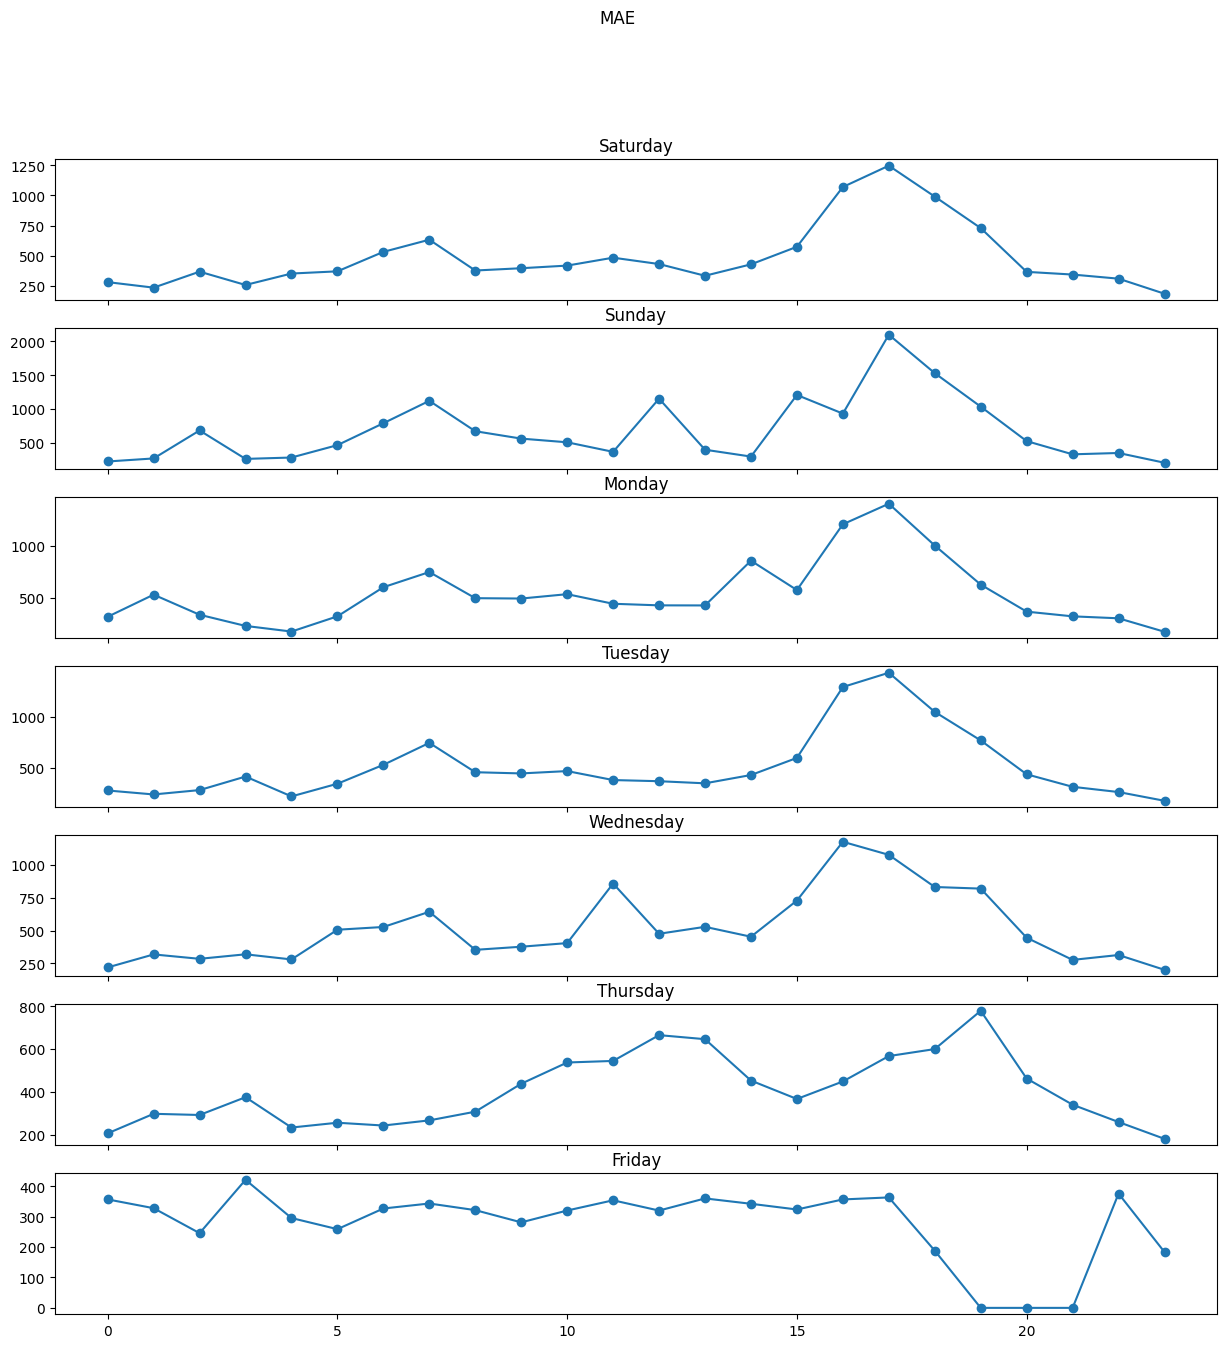

In [28]:
fig, ax = plt.subplots(7, sharex=True, figsize=(15, 15))
days = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

for day in range(7):
    hours = range(day*24, (day+1)*24)
    ax[day].plot(range(24), MAEs_train[hours], '-o', label="MAE")
    ax[day].set_title('{day}'.format(day=days[day]))

fig.suptitle("MAE based on hour")

Text(0.5, 0.98, 'MSE')

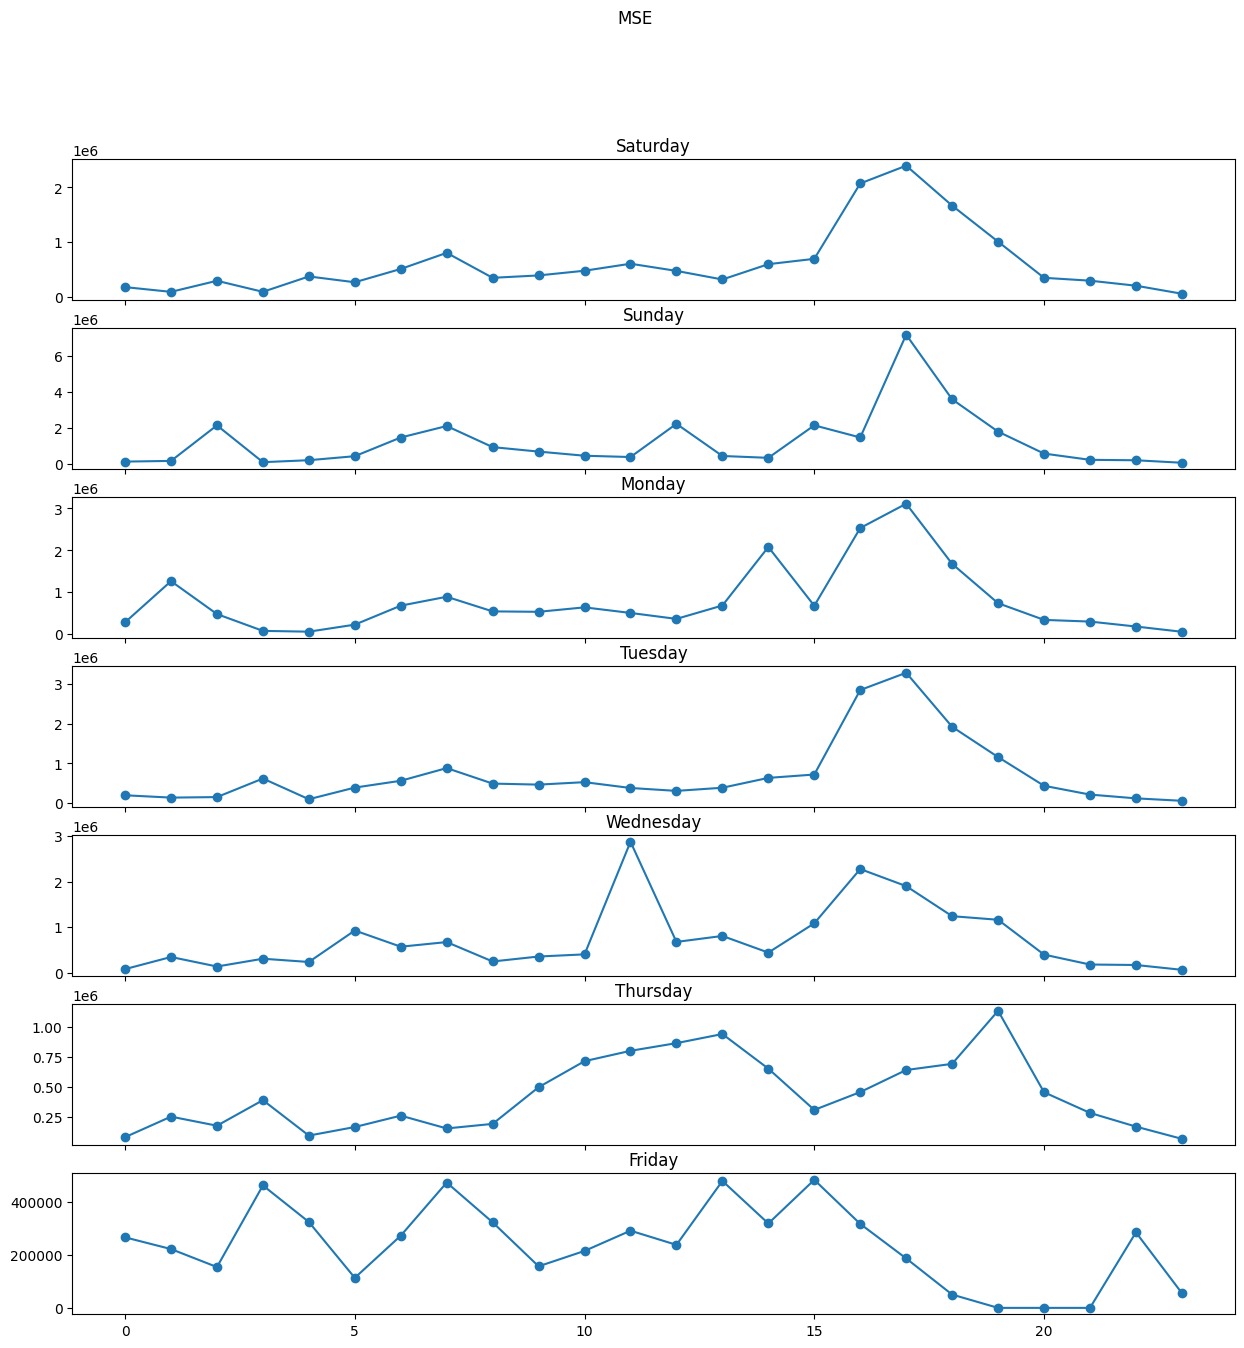

In [29]:
fig, ax = plt.subplots(7, sharex=True, figsize=(15, 15))
days = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

for day in range(7):
    hours = range(day*24, (day+1)*24)
    ax[day].plot(range(24), MSEs_train[hours], '-o', label="MSE")
    ax[day].set_title('{day}'.format(day=days[day]))

fig.suptitle("MSE")

Text(0.5, 0.98, 'R2')

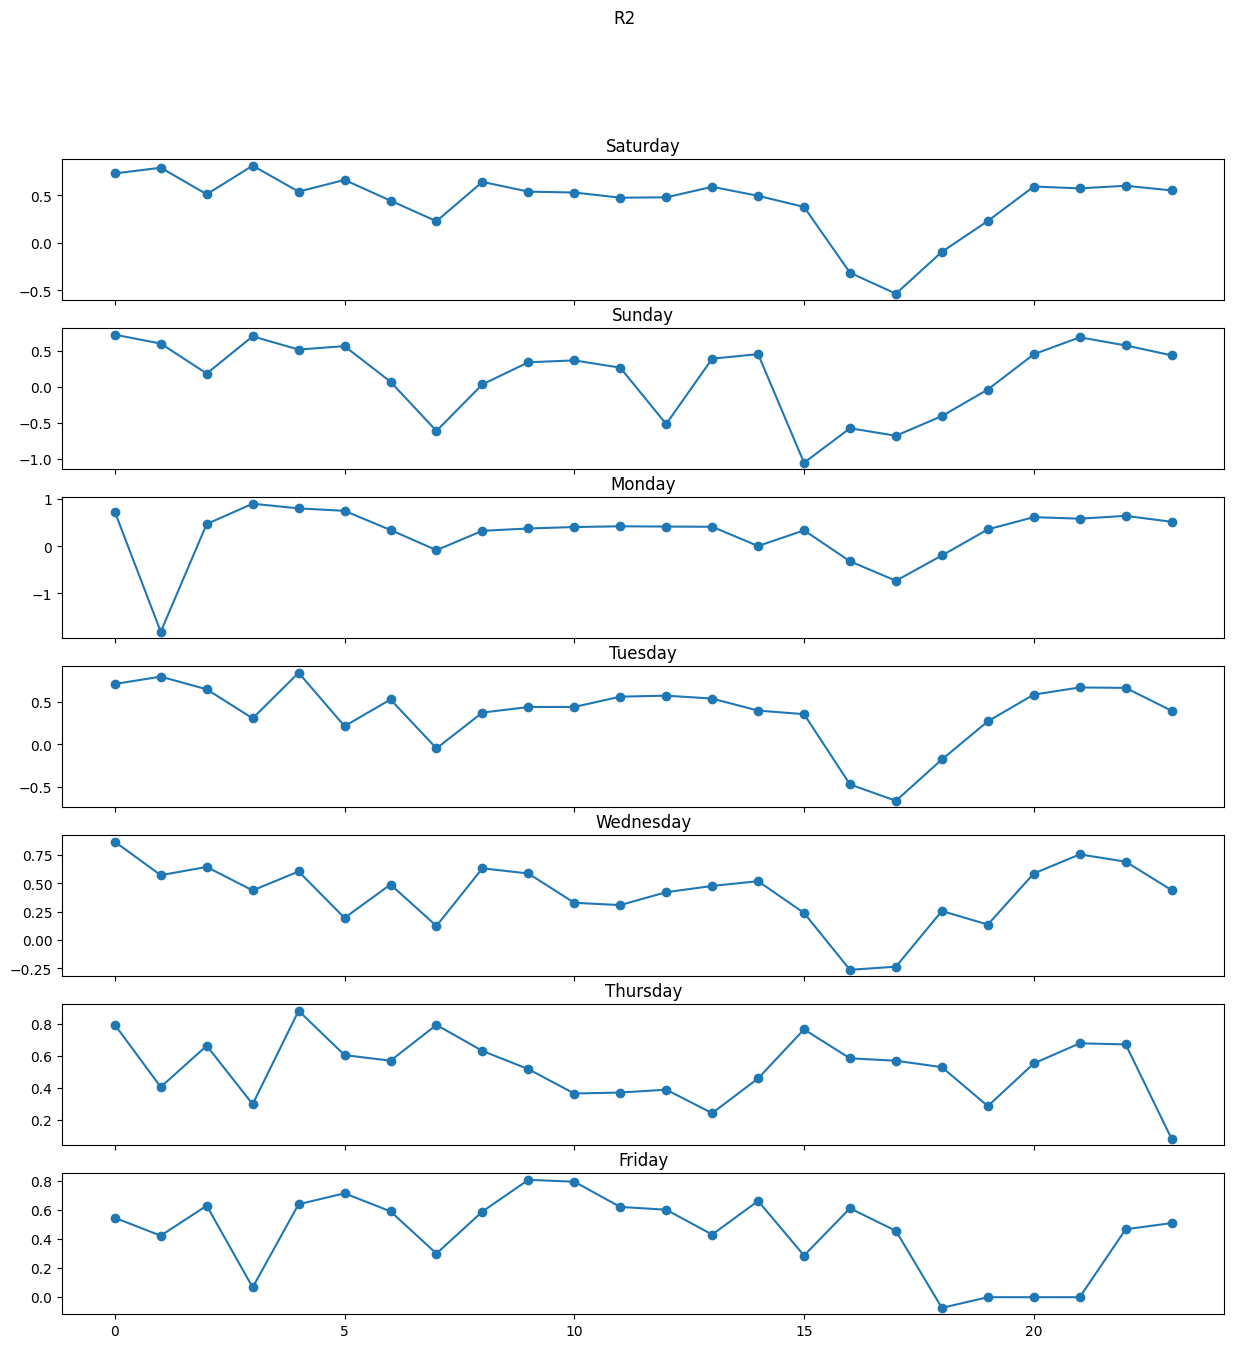

In [30]:
fig, ax = plt.subplots(7, sharex=True, figsize=(15, 15))
days = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

for day in range(7):
    hours = range(day*24, (day+1)*24)
    ax[day].plot(range(24), R2Scores_train[hours], '-o', label="R2")
    ax[day].set_title('{day}'.format(day=days[day]))

fig.suptitle("R2")

Text(0.5, 0.98, 'MAPE')

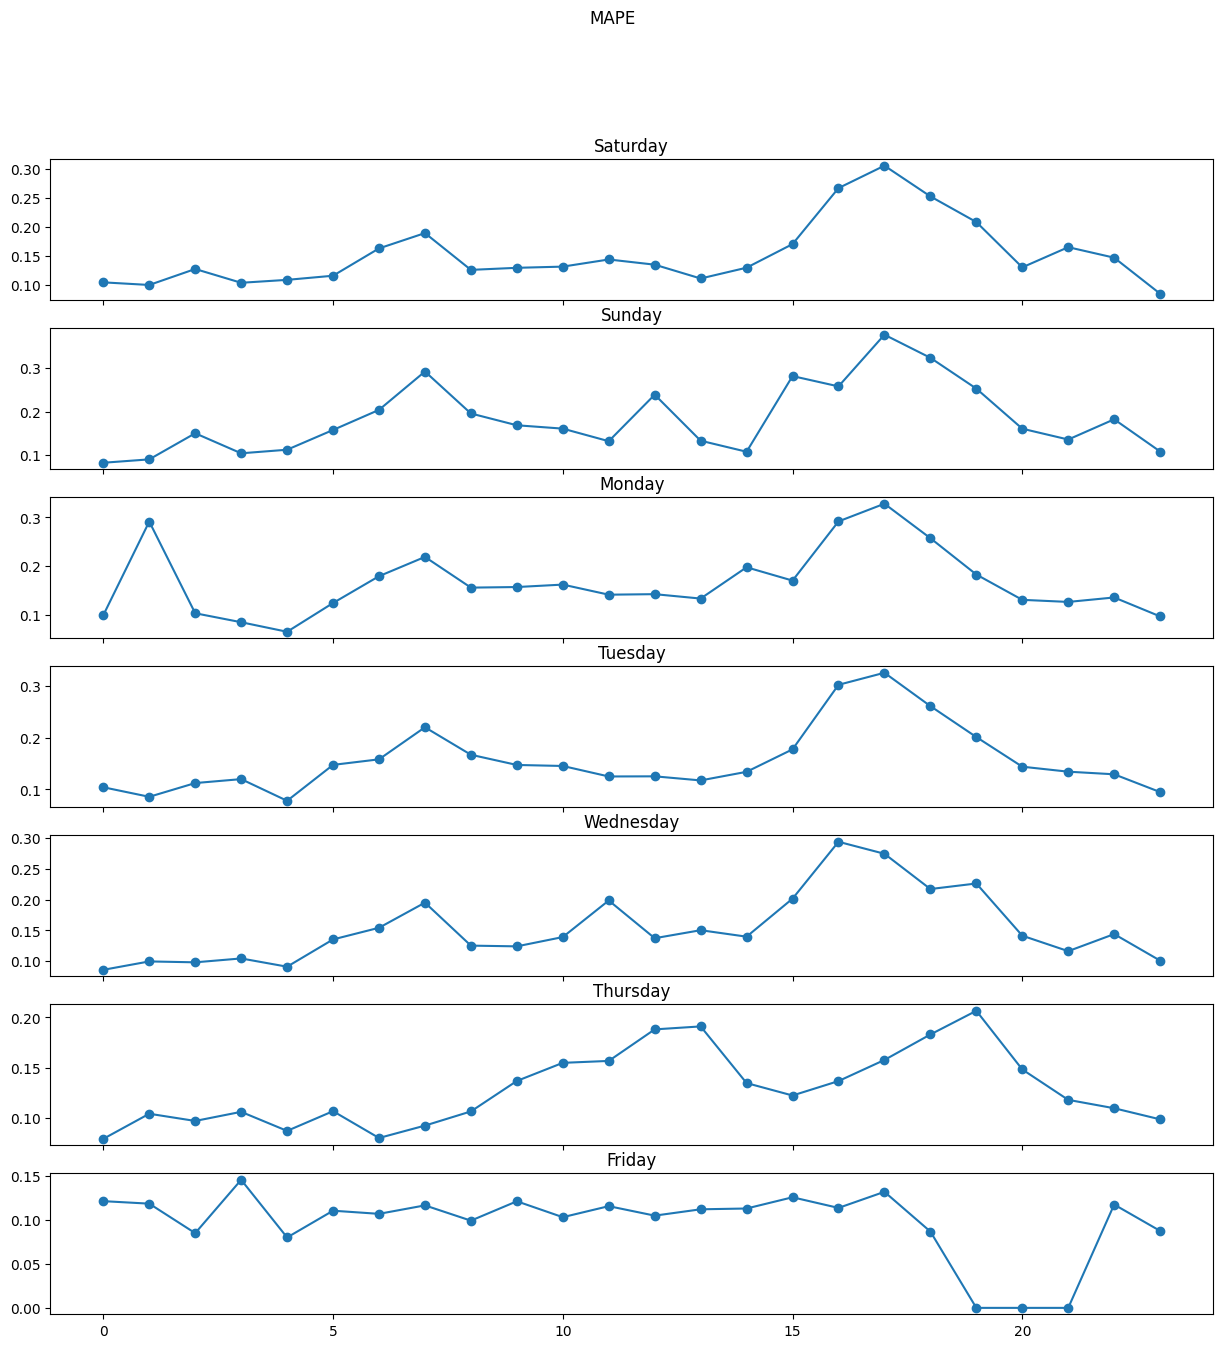

In [31]:
fig, ax = plt.subplots(7, sharex=True, figsize=(15, 15))
days = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

for day in range(7):
    hours = range(day*24, (day+1)*24)
    ax[day].plot(range(24), MAPEs_train[hours], '-o', label="MAPE")
    ax[day].set_title('{day}'.format(day=days[day]))

fig.suptitle("MAPE")

In [23]:
p4_eta_edd_h3_hour_test_transformed

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 2.74700000e+03, 1.36977778e+01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 2.29500000e+03, 1.01902778e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 3.55400000e+03, 7.23583333e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 1.93000000e+03, 1.12622500e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 2.40800000e+03, 1.05943333e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 3.52600000e+03, 1.16656389e+02]])

In [54]:
print("ETA train MAE", mean_absolute_error(p4_ata_train, p4_eta_edd_h3_hour_train_transformed[:, 20]))
print("prediction train MAE", mean_absolute_error(p4_ata_train, p4_ata_train_pred))

print("ETA test MAE ", mean_absolute_error(p4_ata_test, p4_eta_edd_h3_hour_test_transformed[:, 20]))
print("prediction test MAE", mean_absolute_error(p4_ata_test, p4_ata_test_pred))

print("ETA train MSE", mean_squared_error(p4_ata_train, p4_eta_edd_h3_hour_train_transformed[:, 20]))
print("prediction train MSE", mean_squared_error(p4_ata_train, p4_ata_train_pred))

print("ETA test MSE ", mean_squared_error(p4_ata_test, p4_eta_edd_h3_hour_test_transformed[:, 20]))
print("prediction test MSE", mean_squared_error(p4_ata_test, p4_ata_test_pred))

print("ETA train explained_variance_score", explained_variance_score(p4_ata_train, p4_eta_edd_h3_hour_train_transformed[:, 20]))
print("prediction train explained_variance_score", explained_variance_score(p4_ata_train, p4_ata_train_pred))

print("ETA test explained_variance_score ", explained_variance_score(p4_ata_test, p4_eta_edd_h3_hour_test_transformed[:, 20]))
print("prediction test explained_variance_score", explained_variance_score(p4_ata_test, p4_ata_test_pred))

print("ETA train median_absolute_error", median_absolute_error(p4_ata_train, p4_eta_edd_h3_hour_train_transformed[:, 20]))
print("prediction train median_absolute_error", median_absolute_error(p4_ata_train, p4_ata_train_pred))

print("ETA test median_absolute_error ", median_absolute_error(p4_ata_test, p4_eta_edd_h3_hour_test_transformed[:, 20]))
print("prediction test median_absolute_error", median_absolute_error(p4_ata_test, p4_ata_test_pred))

print("ETA train r2_score", r2_score(p4_ata_train, p4_eta_edd_h3_hour_train_transformed[:, 20]))
print("prediction train r2_score", r2_score(p4_ata_train, p4_ata_train_pred))

print("ETA test r2_score ", r2_score(p4_ata_test, p4_eta_edd_h3_hour_test_transformed[:, 20]))
print("prediction test r2_score", r2_score(p4_ata_test, p4_ata_test_pred))

print("ETA train MAPE", mean_absolute_percentage_error(p4_ata_train, p4_eta_edd_h3_hour_train_transformed[:, 20]))
print("prediction train MAPE", mean_absolute_percentage_error(p4_ata_train, p4_ata_train_pred))

print("ETA test MAPE ", mean_absolute_percentage_error(p4_ata_test, p4_eta_edd_h3_hour_test_transformed[:, 20]))
print("prediction test MAPE", mean_absolute_percentage_error(p4_ata_test, p4_ata_test_pred))

ETA train MAE 634.463130797703
prediction train MAE 534.8753241795988
ETA test MAE  534.6667390085544
prediction test MAE 228043281.73379573
ETA train MSE 933804.4980426802
prediction train MSE 606939.7399515673
ETA test MSE  718715.1725173169
prediction test MSE 5.6428918555629486e+20
ETA train explained_variance_score 0.5021595554996434
prediction train explained_variance_score 0.5321789531728258
ETA test explained_variance_score  0.5364170276423786
prediction test explained_variance_score -478721863218078.9
ETA train median_absolute_error 395.0
prediction train median_absolute_error 400.08837890625
ETA test median_absolute_error  322.0
prediction test median_absolute_error 397.58984375
ETA train r2_score 0.28023596240182824
prediction train r2_score 0.5321789531727468
ETA test r2_score  0.3902148045824526
prediction test r2_score -478764334529423.8
ETA train MAPE 0.18234322873580447
prediction train MAPE 0.1805986939715742
ETA test MAPE  0.16332343897479054
prediction test MAPE 2540

<AxesSubplot: >

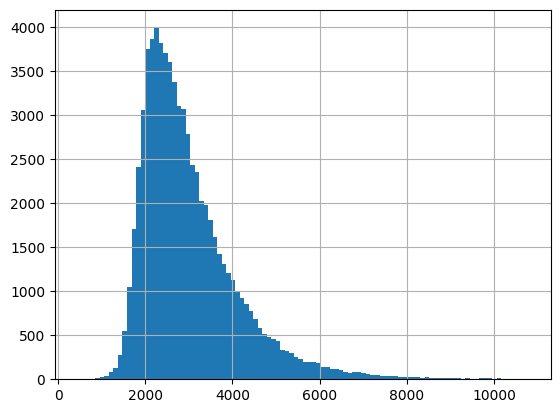

In [105]:
p4_ata_train.hist(bins=100)

<AxesSubplot: >

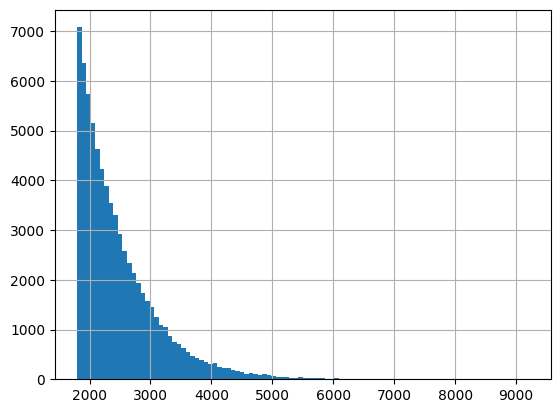

In [108]:
pd.Series(p4_eta_edd_h3_hour_train_transformed[:, 20]).hist(bins=100)

<AxesSubplot: >

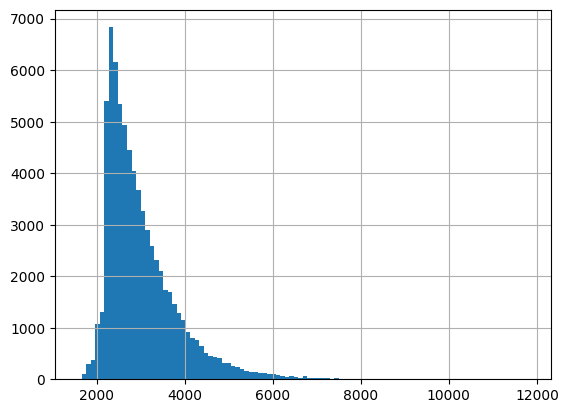

In [110]:
pd.Series(p4_ata_train_pred).hist(bins=100)

In [55]:
p4_ata_test_pred[p4_ata_test_pred < 0]

array([-4.96009123e+09, -4.96008991e+09, -4.96009026e+09, -4.96009017e+09,
       -4.96009393e+09, -4.96009167e+09, -4.96008980e+09, -4.96009108e+09,
       -4.96008988e+09, -4.96009029e+09, -4.96008987e+09, -4.96009058e+09,
       -4.96009468e+09, -4.96009338e+09, -4.96009062e+09, -4.96009378e+09,
       -4.96009111e+09, -4.96009083e+09, -4.96009153e+09, -4.96008956e+09,
       -4.96009158e+09, -4.96009147e+09, -4.96009079e+09, -4.96009486e+09])